#Investigation & Analysis of TMDb (The Movie Database)

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#cf">Conclusions & Findings</a></li>
</ul>

<a id='intro'></a>
## Introduction

 **Questions**
><ul>
    <li> What is the relationship between budget and revenue? (Does budget play a large role in revenue?)</li>
    <lI>Does runtime increase or decrease revenue? Does budget have an effect on runtime?</li>
     <ul>
        <li>What is the distribution of runtime across all movies?</li>
    </ul>
    <lI>Who is the most active (# of movies created) director?</li>
    <ul>
        <li>How does that director relate to the relationships between budget, revenue, and runtime?</li>
    </ul>
></ul>

In [1]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('ggplot')

<a id='wrangling'></a>
## Data Wrangling

In [2]:
#load csv and check if it works
df = pd.read_csv('tmdb_movies.csv')
df.head(2)

,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,...,overview,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj
0,135397,tt0369610,32.985763,150000000,1513528810,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,http://www.jurassicworld.com/,Colin Trevorrow,The park is open.,...,Twenty-two years after the events of Jurassic ...,124,Action|Adventure|Science Fiction|Thriller,Universal Studios|Amblin Entertainment|Legenda...,6/9/15,5562,6.5,2015,1.379999e+08,1.392446e+09
1,76341,tt1392190,28.419936,150000000,378436354,Mad Max: Fury Road,Tom Hardy|Charlize Theron|Hugh Keays-Byrne|Nic...,http://www.madmaxmovie.com/,George Miller,What a Lovely Day.,...,An apocalyptic story set in the furthest reach...,120,Action|Adventure|Science Fiction|Thriller,Village Roadshow Pictures|Kennedy Miller Produ...,5/13/15,6185,7.1,2015,1.379999e+08,3.481613e+08


### Data Cleaning

First, we will check to see if there are any duplicates in our data set.

In [3]:
#check number of duplicates and delete them
print("Number of duplicates:", df.duplicated().sum())
df.drop_duplicates(inplace=True)


Number of duplicates: 1


There is only 1 duplicate in the data set, but we can drop it to ensure we have no duplicates.

In [4]:
#check nubmer of duplicates after deleting them
print("Number of duplicates after dropping:", df.duplicated().sum())

Number of duplicates after dropping: 0


Some columns are not necessary for the questions that we wish to answer. For example, the following columns are not useful: **vote_count, vote_average, popularity, genres, id, imdb_id, cast, homepage, tagline, overview, production_companies, release_date, keywords, release_year, and original_title** to answer questions about **Revenue, Directors, and Budget.**

In [5]:
#drop columns that will not be needed to answer questions above
df.drop(['vote_count', 'vote_average', 'popularity','genres','id', 'imdb_id', 'cast', 'homepage', 'tagline', 'overview', 'production_companies', 'release_date', 'keywords', 'release_year', 'original_title'], axis=1, inplace=True)

In [6]:
#check if drop worked
df.head(2)

,budget,revenue,director,runtime,budget_adj,revenue_adj
0,150000000,1513528810,Colin Trevorrow,124,1.379999e+08,1.392446e+09
1,150000000,378436354,George Miller,120,1.379999e+08,3.481613e+08


We will now check for any empty values and come up with some sort of solution for those.

In [7]:
#check for empty values
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10865 entries, 0 to 10865
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   budget       10865 non-null  int64  
 1   revenue      10865 non-null  int64  
 2   director     10821 non-null  object 
 3   runtime      10865 non-null  int64  
 4   budget_adj   10865 non-null  float64
 5   revenue_adj  10865 non-null  float64
dtypes: float64(2), int64(3), object(1)
memory usage: 594.2+ KB


10865 is the total number of rows that we have data for. There seem to be missing values in **Director**.
First, we will compare the total data to the data in the missing value column.

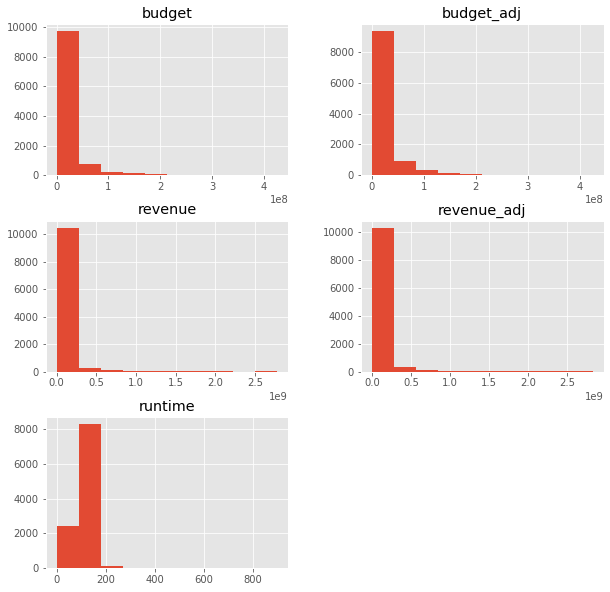

In [9]:
#histogram of all data
df.hist(figsize=[10,10]);
plt.savefig('histogram_all_data.png')

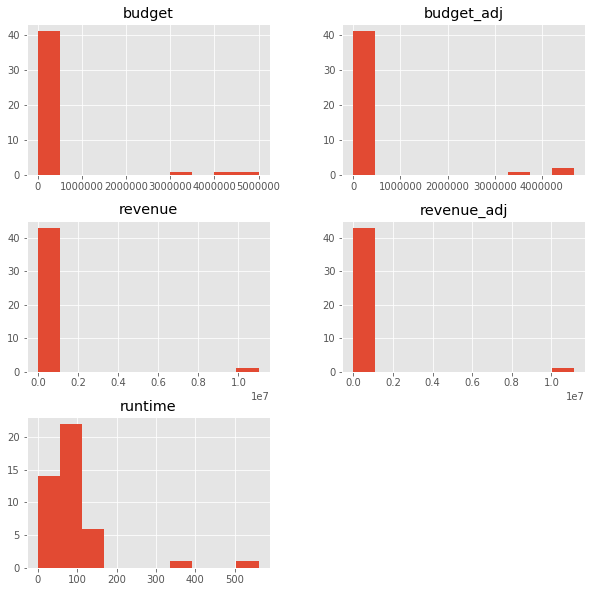

In [10]:
#histogram of null director column data
df[df.director.isnull()].hist(figsize=(10,10));
plt.savefig('histogram_null_director_data.png')

The missing values in **Director** seem to be consistent with the values of the original dataframe.

In [11]:
#check for % of missing values to see if it is reasonable to just drop the missing rows
total_rows = 10865
director_rows = 10821
director_total_missing = total_rows - director_rows

print("The missing values consist of", director_total_missing / total_rows * 100, "% of the rows in the Director column.")

The missing values consist of 0.40497008743672336 % of the rows in the Director column.


Additionally, the missing value consists of only .4% of the total original data. This conclusion and the previous histograms seem to indicate that it will be okay to drop the missing rows.

In [12]:
#drop missing value rows
df.dropna(inplace=True)

In [13]:
#check to see if we are consistent in regards to # of rows
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10821 entries, 0 to 10865
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   budget       10821 non-null  int64  
 1   revenue      10821 non-null  int64  
 2   director     10821 non-null  object 
 3   runtime      10821 non-null  int64  
 4   budget_adj   10821 non-null  float64
 5   revenue_adj  10821 non-null  float64
dtypes: float64(2), int64(3), object(1)
memory usage: 591.8+ KB


We now are consistent in our data set and have a total of 10821 rows.

In [14]:
#check for values of 0
df.describe()

,budget,revenue,runtime,budget_adj,revenue_adj
count,1.082100e+04,1.082100e+04,10821.000000,1.082100e+04,1.082100e+04
mean,1.468259e+07,3.998782e+07,102.130302,1.762011e+07,5.157685e+07
std,3.096345e+07,1.172186e+08,30.872755,3.435943e+07,1.448953e+08
min,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,90.000000,0.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00,99.000000,0.000000e+00,0.000000e+00
75%,1.500000e+07,2.433232e+07,111.000000,2.099042e+07,3.398486e+07
max,4.250000e+08,2.781506e+09,900.000000,4.250000e+08,2.827124e+09


**Budget, Revenue, Budget_adj, Runtime and Revenue_adj** all seem to have some values of 0. We should obtain the average of each column and fill out any 0 values with this result.

In [15]:
#fix values of 0 by replacing 0's with the average of that column
budget_mean = df['budget'].mean()
df['budget'] = df['budget'].replace(0, budget_mean)

budget_adj_mean = df['budget_adj'].mean()
df['budget_adj'] = df['budget_adj'].replace(0, budget_adj_mean)

revenue_mean = df['revenue'].mean()
df['revenue'] = df['revenue'].replace(0, revenue_mean)

revenue_adj_mean = df['revenue_adj'].mean()
df['revenue_adj'] = df['revenue_adj'].replace(0, revenue_adj_mean)

runtime_mean = df['runtime'].mean()
df['runtime'] = df['runtime'].replace(0, runtime_mean)

In [16]:
#check to see if 0's are no longer missing
df.describe()

,budget,revenue,runtime,budget_adj,revenue_adj
count,1.082100e+04,1.082100e+04,10821.000000,1.082100e+04,1.082100e+04
mean,2.235699e+07,6.206039e+07,102.404009,2.682992e+07,8.004635e+07
std,2.805607e+07,1.112216e+08,30.415387,3.055240e+07,1.368048e+08
min,1.000000e+00,2.000000e+00,2.000000,9.210911e-01,2.370705e+00
25%,1.468259e+07,3.998782e+07,90.000000,1.762011e+07,5.157685e+07
50%,1.468259e+07,3.998782e+07,99.000000,1.762011e+07,5.157685e+07
75%,1.500000e+07,3.998782e+07,111.000000,2.099042e+07,5.157685e+07
max,4.250000e+08,2.781506e+09,900.000000,4.250000e+08,2.827124e+09


Finally, we should check if there are any "bad" datatypes for the set of data that we will be working with.

In [17]:
#check for bad datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10821 entries, 0 to 10865
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   budget       10821 non-null  float64
 1   revenue      10821 non-null  float64
 2   director     10821 non-null  object 
 3   runtime      10821 non-null  float64
 4   budget_adj   10821 non-null  float64
 5   revenue_adj  10821 non-null  float64
dtypes: float64(5), object(1)
memory usage: 591.8+ KB


Everything seems to have the appropriate data type. Let's save this to a new csv file so we can work with only the edited data.

In [18]:
#save cleaned dataframe as new csv
df.to_csv('tmdb_movies_edited.csv', index=False)

Check to see if it worked and set it to a new dataframe.

In [19]:
#import new csv and check to see if it worked
df_edited = pd.read_csv('tmdb_movies_edited.csv')
df_edited.head(2)

,budget,revenue,director,runtime,budget_adj,revenue_adj
0,150000000.0,1.513529e+09,Colin Trevorrow,124.0,1.379999e+08,1.392446e+09
1,150000000.0,3.784364e+08,George Miller,120.0,1.379999e+08,3.481613e+08


<a id='eda'></a>
## Exploratory Data Analysis

### What is the relationship between budget and revenue? (Does budget play a large role in revenue?)

The first that we should do is plot the relationship between budget and revenue.

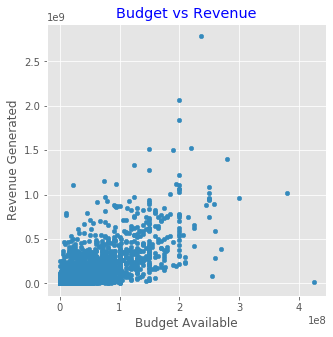

In [20]:
#plot the relationship between budget and revenue
df_edited.plot(x='budget', y='revenue', kind='scatter', figsize=[5,5])

plt.title('Budget vs Revenue', color='blue')
plt.xlabel('Budget Available')
plt.ylabel('Revenue Generated')
plt.savefig('budget_revenue.png');

It seems like having a larger budget does not mean you will see larger revenue numbers, but lets adjust for inflation just to make sure.

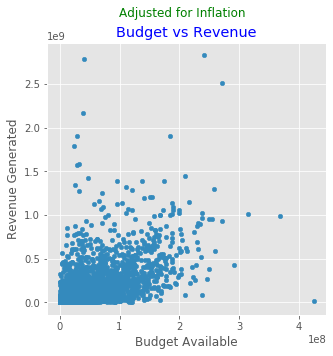

In [21]:
#plot the relationship between budget and revenue when adjusted for inflation
df_edited.plot(x='budget_adj', y='revenue_adj', kind='scatter', figsize=[5,5])

plt.title('Budget vs Revenue', color='blue')
plt.suptitle('Adjusted for Inflation', color='green')
plt.xlabel('Budget Available')
plt.ylabel('Revenue Generated')
plt.savefig('budget_revenue_inflation.png');

Not only is our previous statement true. *"Having a larger budget does not mean you will see larger revenue numbers..."*, but in fact it seems that there are many movies that actually were more successful (in regards to revenue) on a lower budget when adjusted for inflation!

### Does runtime increase or decrease revenue? Does budget have an effect on runtime?

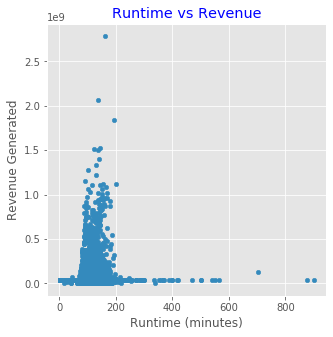

In [22]:
#plot the relationship between runtime and revenue
df_edited.plot(x='runtime', y='revenue', kind='scatter', figsize=[5,5])

plt.title('Runtime vs Revenue', color='blue')
plt.xlabel('Runtime (minutes)')
plt.ylabel('Revenue Generated')
plt.savefig('runtime_revenue.png');

Runtime does seem to have an effect on revenue. Movies that have a runtime of **less than 90 minutes** make **SIGNIFICANTLY** less revenue. Movies that have a runtime of **more than 200 minutes** make **SIGNIFICANTLY** less revenue. The sweet spot for generating the most revenue seems to be around the median for runtime which happens to be around **100 minutes** (1 hour, 30 minutes).

Let's get an idea of the runtime distribution of movies in our dataframe.

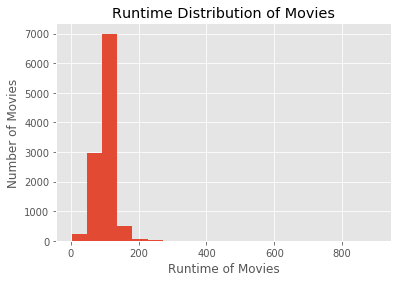

In [23]:
#plot the runtime distribution of all movies
plt.hist(df_edited['runtime'], bins =20);
plt.title('Runtime Distribution of Movies')
plt.xlabel('Runtime of Movies')
plt.ylabel('Number of Movies')
plt.savefig('runtime_distribution_movies.png');

The runtime distribution of movies is right skewed. The mode of movies is around 90 minutes, which is nearly the "sweet spot" that I mentioned earlier for generating the most revenue.

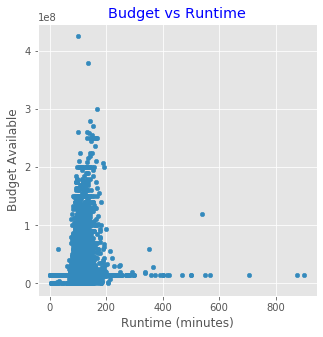

In [24]:
#plot the relationship between budget and runtime
df_edited.plot(x='runtime', y='budget', kind='scatter', figsize=[5,5])

plt.title('Budget vs Runtime', color='blue')
plt.xlabel('Runtime (minutes)')
plt.ylabel('Budget Available')
plt.savefig('budget_runtime.png');

Budget does seem to have an effect on runtime, but in an opposite way of what most people would think. If you have a higher budget, it would make sense that you would be able to use it to have a longer runtime. That being said, it seems like movies with the longest runtime actually had some of the lowest budgets available.

If you are a director and want to create a successful (in regards to revenue) movie, it would be in your best interest to aim for **100 minutes** of runtime. Additionally, you should **not worry about having an incredibly high budget**, because an average budget will generally do better.

### Who are the most active (# of movies created) directors?

In [25]:
#use value_counts to see who the most active director is
count_directors = df_edited['director'].value_counts()
#check to see how far ahead he is of the next directors
count_directors.head(10)

Woody Allen          45
Clint Eastwood       34
Martin Scorsese      29
Steven Spielberg     29
Ridley Scott         23
Steven Soderbergh    22
Ron Howard           22
Joel Schumacher      21
Brian De Palma       20
Tim Burton           19
Name: director, dtype: int64

Woody Allen is the most active director with an incredible total of 45 movies directed. This is an incredible outlier compared to the rest of the data.

In [26]:
# get the averages of Woody Allen's budget, revenue, runtime, and budget adjusted for inflation as well as revenue adjusted for inflation
top_director_averages = df_edited.loc[df_edited['director'] == 'Woody Allen'].mean()
top_director_averages

budget         1.344559e+07
revenue        3.937210e+07
runtime        9.562222e+01
budget_adj     1.809816e+07
revenue_adj    5.512195e+07
dtype: float64

>If we convert 9.562222e+01 from scientific notation to a real number, we get 95.62 minutes.
>Movies that have around a 100 minute runtime seem to be the most successful. Woody Allen is not far off that mark on average, so let's see if he has a good budget to revenue ratio.

>Woody Allen's average budget is `$13,445,590` while his average revenue is `$39,372,100`. Adjusted for inflation, he is even more successful.

<a id='cf'></a>
## Conclusions & Findings


### What is the relationship between budget and revenue? (Does budget play a large role in revenue?)
A larget budget does not seem to generate larger revenue numbers. Adjusted for inflation, a larger budget once again does not seem to generate larger revenue numbers. That being said, when adjusted for inflation, it does seem that many movies were actually more successful (in regards to revenue generated) on a lower budget.


### Does runtime increase or decrease revenue? Does budget have an effect on runtime?
Revenue does seem to be effected by runtime.

<il>
    <li>Movies that have a runtime of <b>less than 90 minutes</b> make <b>SIGNIFICANTLY</b> less revenue.</li>
    <li>Movies that have a runtime of <b>more than 200 minutes</b> make <b>SIGNIFICANTLY</b> less revenue.</li>
    <li>Movies that have an <b>average runtime of about 100 minutes</b> (1hour, 30 minutes) seem to generate the most revenue.</li>
</ul>

#### What is the distribution of runtime across all movies?
The mode of movies is about 90 minutes. The runtime distribution of movies is also right skewed.

### Who is the most active (# of movies created) director?
Woody Allen is the most active director. He has directed 45 movies.

##### How does that director relate to the relationships between budget, revenue, and runtime?
 Woody Allen's average runtime for all of his 45 movies is <b>95.62 minutes</b>. That is extremely close to the 100 minute runtime mark that seems to be an indicator for the most revenue generation.

He also has a great revenue to budget ratio.
<il>
    <li>Woody Allen's average budget: `$13,445,590`</li>
    <li>Woody Allen's average revenue: `$39,372,100`</li>
    <li>Adjusted for inflation, Woody Allen has an even better revenue to budget ratio at nearly 1:5.</li>
</ul>